In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#| default_exp helpers

In [ ]:
#| export
import math, os, json, time, uuid
import numpy as np
from collections import Counter
from typing import Any, Dict, List, Tuple
from matplotlib import colors       
import matplotlib.pyplot as plt
import plotly.io as pio

# ListChecker

In [ ]:
#| export
class ListChecker:
    
    @staticmethod
    def check_list_unchanged(float_list, rel_tol=1e-9, abs_tol=0.0, gradient_abs_tol=0.0):
        """
        Checks if the list values are unchanged by calculating their gradient, mean, and standard deviation.

        Returns:
            bool: True if the list values are close to each other within the specified tolerance.
            dict: A dictionary containing the gradient, mean, and standard deviation of the list values.
        """
        if not float_list:
            return True, {"gradient": None, "mean": None, "std_dev": None}

        first_value = float_list[0]

        all_close_to_first = all(
            math.isclose(value, first_value, rel_tol=rel_tol, abs_tol=abs_tol)
            for value in float_list[1:]
        )

        gradients = np.gradient(float_list)
        mean_value = np.mean(float_list)
        std_dev = np.std(float_list)

        gradient_range = abs(max(gradients) - min(gradients))        
        gradient_range_close_to_zero = math.isclose(gradient_range, 0, rel_tol=0, abs_tol=gradient_abs_tol)

        return all_close_to_first and gradient_range_close_to_zero, {"gradient_range": gradient_range, "mean": mean_value, "std_dev": std_dev}

    @staticmethod
    def check_float_list_close_to_zero(float_list, rel_tol=1e-9, abs_tol=0.0):
        """
        Checks if the values in the float list are close to zero within the specified tolerance
        and if the gradient (difference between consecutive values) is close to zero within the specified gradient tolerance.

        Returns:
            bool: True if all values are close to zero within the specified tolerance and the gradient of all consecutive values is close to zero within the specified gradient tolerance.
        """
        if not float_list:
            return True
        
        values_close_to_zero = all(
            math.isclose(value, 0, rel_tol=rel_tol, abs_tol=abs_tol)
            for value in float_list
        )
            
        return values_close_to_zero
        


    @staticmethod
    def check_float_list_close_to_zero1(float_list, rel_tol=1e-9, abs_tol=0.0):
        """
        Checks if the values in the float list are close to zero within the specified tolerance.

        Returns:
            bool: True if all values are close to zero within the specified tolerance.
        """
        if not float_list:
            return True

        gradient = np.gradient(float_list)    
        gradient_mean = gradient.mean()        

        values_close_to_zero = all(
            math.isclose(value, 0, rel_tol=rel_tol, abs_tol=abs_tol)
            for value in float_list
        )

        return values_close_to_zero, gradient_mean, gradient


    @staticmethod
    def check_integer_list_unchanged(int_list):
        """
        Checks if all integers in the list are unchanged (i.e., equal).

        Returns:
            bool: True if all integers are the same.
        """
        if not int_list:
            return True
        first_value = int_list[0]
        for value in int_list:
            if value != first_value:
                return False
        return True






## check_float_list_close_to_zero

In [ ]:
# @staticmethod
# def check_float_list_close_to_zero(float_list, rel_tol=1e-9, abs_tol=0.0, gradient_abs_tol=0.0):
#     """
#     Checks if the values in the float list are close to zero within the specified tolerance
#     and if the gradient (difference between consecutive values) is close to zero within the specified gradient tolerance.

#     Returns:
#         bool: True if all values are close to zero within the specified tolerance and the gradient of all consecutive values is close to zero within the specified gradient tolerance.
#     """
#     if not float_list:
#         return True
    
#     values_close_to_zero = all(
#         math.isclose(value, 0, rel_tol=rel_tol, abs_tol=abs_tol)
#         for value in float_list
#     )
    
#     if len(float_list) == 1:
#         return values_close_to_zero
    
#     gradients_close_to_zero = all(
#         math.isclose(float_list[i] - float_list[i - 1], 0, rel_tol=0, abs_tol=gradient_abs_tol)
#         for i in range(1, len(float_list))
#     )
    
#     return values_close_to_zero and gradients_close_to_zero

## check_float_list_close_to_zero

In [ ]:
# @staticmethod
# def check_float_list_close_to_zero(float_list, rel_tol=1e-9, abs_tol=0.0, gradient_abs_tol=0.0):
#     """
#     Checks if the values in the float list are close to zero within the specified tolerance
#     and if the gradient (difference between consecutive values) is close to zero within the specified gradient tolerance.

#     Returns:
#         bool: True if all values are close to zero within the specified tolerance and the gradient of all consecutive values is close to zero within the specified gradient tolerance.
#     """
#     if not float_list:
#         return True
    
#     values_close_to_zero = all(
#         math.isclose(value, 0, rel_tol=rel_tol, abs_tol=abs_tol)
#         for value in float_list
#     )
    
#     if len(float_list) == 1:
#         return values_close_to_zero
    
#     gradients_close_to_zero = all(
#         math.isclose(float_list[i] - float_list[i - 1], 0, rel_tol=0, abs_tol=gradient_abs_tol)
#         for i in range(1, len(float_list))
#     )
    
#     return values_close_to_zero and gradients_close_to_zero

## check_float_list_close_to_zero

In [ ]:
# @staticmethod
# def check_float_list_close_to_zero(float_list, rel_tol=1e-9, abs_tol=0.0, gradient_abs_tol=0.0):
#     """
#     Checks if the values in the float list are close to zero within the specified tolerance
#     and if the gradient (difference between consecutive values) is close to zero within the specified gradient tolerance.

#     Returns:
#         bool: True if all values are close to zero within the specified tolerance and the gradient of all consecutive values is close to zero within the specified gradient tolerance.
#     """
#     if not float_list:
#         return True
    
#     values_close_to_zero = all(
#         math.isclose(value, 0, rel_tol=rel_tol, abs_tol=abs_tol)
#         for value in float_list
#     )
    
#     if len(float_list) == 1:
#         return values_close_to_zero
    
#     gradients_close_to_zero = all(
#         math.isclose(float_list[i] - float_list[i - 1], 0, rel_tol=0, abs_tol=gradient_abs_tol)
#         for i in range(1, len(float_list))
#     )
    
#     return values_close_to_zero and gradients_close_to_zero

## check_float_list_close_to_zero

In [ ]:
# @staticmethod
# def check_float_list_close_to_zero(float_list, rel_tol=1e-9, abs_tol=0.0, gradient_abs_tol=0.0):
#     """
#     Checks if the values in the float list are close to zero within the specified tolerance
#     and if the gradient (difference between consecutive values) is close to zero within the specified gradient tolerance.

#     Returns:
#         bool: True if all values are close to zero within the specified tolerance and the gradient of all consecutive values is close to zero within the specified gradient tolerance.
#     """
#     if not float_list:
#         return True
    
#     values_close_to_zero = all(
#         math.isclose(value, 0, rel_tol=rel_tol, abs_tol=abs_tol)
#         for value in float_list
#     )
    
#     if len(float_list) == 1:
#         return values_close_to_zero
    
#     gradients_close_to_zero = all(
#         math.isclose(float_list[i] - float_list[i - 1], 0, rel_tol=0, abs_tol=gradient_abs_tol)
#         for i in range(1, len(float_list))
#     )
    
#     return values_close_to_zero and gradients_close_to_zero

In [ ]:

# Example usage:
float_list = [1.00000001, 1.00000002, 1.00000003]
int_list = [1, 1, 1]

print(ListChecker.check_list_unchanged(float_list))  # Should print: True (depending on the tolerance)
print(ListChecker.check_integer_list_unchanged(int_list))  # Should print: True


(False, {'gradient_range': 2.220446049250313e-16, 'mean': 1.0000000199999999, 'std_dev': 8.164965850304249e-09})
True


# ARC Data

## JSONDataManager

In [ ]:
#| export
class JSONDataManager:
    def __init__(self, path: str, show_timing: bool = False):
        self.data = self.load_json(path)
        self.show_timing = show_timing
    
    
    def load_json(self, path: str) -> Dict:
        with open(path, 'r') as file:
            return json.load(file)
    
    def timing_decorator(method):
        def timed_method(self, *args, **kwargs):
            start_time = time.time()
            result = method(self, *args, **kwargs)
            end_time = time.time()
            if self.show_timing:
                print(f"Execution time of {method.__name__}: {end_time - start_time:.4f} seconds")
            return result
        return timed_method

    def reload_data(self, path: str):
        self.data = self.load_json(path)

In [ ]:
# #| export
# class JSONDataManager:
#     def __init__(self, path: str, show_timing: bool = False):
#         self.data = self.load_json(path)
#         self.show_timing = show_timing
    
#     @JSONDataManager.timing_decorator
#     def load_json(self, path: str) -> Dict:
#         with open(path, 'r') as file:
#             return json.load(file)
    
#     def timing_decorator(method):
#         def timed_method(self, *args, **kwargs):
#             start_time = time.time()
#             result = method(self, *args, **kwargs)
#             end_time = time.time()
#             if self.show_timing:
#                 print(f"Execution time of {method.__name__}: {end_time - start_time:.4f} seconds")
#             return result
#         return timed_method

#     def reload_data(self, path: str):
#         self.data = self.load_json(path)

In [ ]:
# import json
# import time
# from typing import Dict

# def timing_decorator(method):
#     def timed_method(self, *args, **kwargs):
#         start_time = time.time()
#         result = method(self, *args, **kwargs)
#         end_time = time.time()
#         if self.show_timing:
#             print(f"Execution time of {method.__name__}: {end_time - start_time:.4f} seconds")
#         return result
#     return timed_method

# class JSONDataManager:
#     def __init__(self, path: str, show_timing: bool = False):
#         self.data = self.load_json(path)
#         self.show_timing = show_timing
    
#     @timing_decorator
#     def load_json(self, path: str) -> Dict:
#         with open(path, 'r') as file:
#             return json.load(file)

#     def reload_data(self, path: str):
#         self.data = self.load_json(path)


## ChallengesDataManager

In [ ]:
#| export

class ChallengesDataManager(JSONDataManager):
    
    @JSONDataManager.timing_decorator
    def __init__(self, path: str, show_timing: bool = False):
        super().__init__(path, show_timing)
    

    @JSONDataManager.timing_decorator
    def get_all_keys(self) -> List[str]:
        return list(self.data.keys())
    
    @JSONDataManager.timing_decorator
    def count_all_keys(self) -> int:
        return len(self.data)
    
    @JSONDataManager.timing_decorator
    def get_keys_with_equal_size_input_output(self) -> Tuple[List[str], int]:
        equal_keys = [
            key for key, value in self.data.items()
            if all(
                np.array(value['train'][iter]['input']).shape == np.array(value['train'][iter]['output']).shape and
                np.array(value['train'][iter]['input']).shape[0] == np.array(value['train'][iter]['input']).shape[1]
                for iter in range(len(value['train']))
            )
        ]
        return equal_keys, len(equal_keys)
    
    @JSONDataManager.timing_decorator
    def get_keys_with_equal_size_input_output_sorted(self) -> List[Tuple[str, int]]:
        equal_keys = [
            (key, len(value['train'][0]['input'])) for key, value in self.data.items()
            if all(
                np.array(value['train'][iter]['input']).shape == np.array(value['train'][iter]['output']).shape and
                np.array(value['train'][iter]['input']).shape[0] == np.array(value['train'][iter]['input']).shape[1]
                for iter in range(len(value['train'])))
        ]
        equal_keys_sorted = sorted(equal_keys, key=lambda x: x[1])
        return equal_keys_sorted

    @JSONDataManager.timing_decorator
    def get_keys_with_inconsistent_input_output_sizes(self) -> Tuple[List[str], int]:
        inconsistent_keys = []
        for key, value in self.data.items():
            input_sizes = [len(value['train'][iter]['input']) for iter in range(len(value['train']))]
            output_sizes = [len(value['train'][iter]['output']) for iter in range(len(value['train']))]
            if len(set(input_sizes)) == 1 and len(set(output_sizes)) == 1 and input_sizes[0] < output_sizes[0]:
                inconsistent_keys.append(key)
        return inconsistent_keys, len(inconsistent_keys)
    
    @JSONDataManager.timing_decorator
    def get_keys_with_variable_input_sizes(self) -> Tuple[List[str], int]:
        variable_keys = [
            key for key, value in self.data.items()
            if len(set(len(value['train'][iter]['input']) for iter in range(len(value['train'])))) > 1
        ]
        return variable_keys, len(variable_keys)
    
    @JSONDataManager.timing_decorator
    def get_input_array_histogram(self) -> Dict[int, int]:
        counts = Counter(len(value['train']) for value in self.data.values())
        return dict(counts)
    
    # @JSONDataManager.timing_decorator
    def get_data_for_key(self, key: str) -> Dict[str, Any]:
        if key not in self.data:
            raise KeyError(f"Key '{key}' not found in data.")
        return self.data[key]
    
    @JSONDataManager.timing_decorator
    def get_arrays_for_key(self, key: str, array_type: str) -> List:
        if key not in self.data or 'train' not in self.data[key] or array_type not in self.data[key]['train']:
            return []
        return self.data[key]['train'][array_type]
    
    @JSONDataManager.timing_decorator
    def get_largest_array_size(self) -> Tuple[str, int]:
        max_size = 0
        max_key = ''
        for key, value in self.data.items():
            input_sizes = [np.array(value['train'][iter]['input']).size for iter in range(len(value['train']))]
            output_sizes = [np.array(value['train'][iter]['output']).size for iter in range(len(value['train']))]

            max_input_size = max(input_sizes, default=0)
            max_output_size = max(output_sizes, default=0)
            if max(max_input_size, max_output_size) > max_size:
                max_size = max(max_input_size, max_output_size)
                max_key = key
        return max_key, max_size

    @JSONDataManager.timing_decorator
    def analyze_arrays(self) -> Dict[str, Any]:
        analysis = {
            "equal_input_output": [],
            "consistent_but_different_sizes": [],
            "variable_output_sizes": []
        }
        for key, value in self.data.items():
            input_sizes = [np.array(value['train'][iter]['input']).size for iter in range(len(value['train']))]
            output_sizes = [np.array(value['train'][iter]['output']).size for iter in range(len(value['train']))]
            if all(size == input_sizes[0] for size in input_sizes) and all(size == output_sizes[0] for size in output_sizes):
                if input_sizes[0] == output_sizes[0]:
                    analysis["equal_input_output"].append(key)
                else:
                    analysis["consistent_but_different_sizes"].append(key)
            else:
                analysis["variable_output_sizes"].append(key)
        
        return {
            "analysis": analysis,
            "counts": {k: len(v) for k, v in analysis.items()}
        }


    @JSONDataManager.timing_decorator
    def reload_data(self, path: str):
        super().reload_data(path)


## SolutionsDataManager

In [ ]:
#| export

class SolutionsDataManager(JSONDataManager):

    @JSONDataManager.timing_decorator
    def __init__(self, path: str, show_timing: bool = False):
        super().__init__(path, show_timing)
    

    @JSONDataManager.timing_decorator
    def get_all_keys(self) -> List[str]:
        return list(self.data.keys())
    
    @JSONDataManager.timing_decorator
    def count_all_keys(self) -> int:
        return len(self.data)
    
    # @JSONDataManager.timing_decorator
    def get_data_for_key(self, key: str) -> Dict[str, Any]:
        if key not in self.data:
            raise KeyError(f"Key '{key}' not found in data.")
        return self.data[key][0]    

    @JSONDataManager.timing_decorator
    def get_arrays_for_key(self, key: str, array_type: str) -> List:
        if key not in self.data or array_type not in self.data[key]:
            return []
        return self.data[key][array_type]

    @JSONDataManager.timing_decorator
    def reload_data(self, path: str):
        super().reload_data(path)


In [ ]:
#| gui
# Example usage
start_time = time.time()
challenges_manager = ChallengesDataManager("C:\\packages\\arc-prize-2024\\arc-agi_training_challenges.json")
end_time = time.time()
print(f"Execution time of challenges load: {end_time - start_time:.4f} seconds")

start_time = time.time()
solutions_manager = SolutionsDataManager("C:\\packages\\arc-prize-2024\\arc-agi_training_solutions.json")
end_time = time.time()
print(f"Execution time of solutions load: {end_time - start_time:.4f} seconds")

print(challenges_manager.get_all_keys())
print(challenges_manager.count_all_keys())
print('get_keys_with_equal_size_input_output')
gkweqsio = challenges_manager.get_keys_with_equal_size_input_output()
print(gkweqsio[0])
print(gkweqsio[1])
print('get_keys_with_equal_size_input_output_sorted')
gkweqsios = challenges_manager.get_keys_with_equal_size_input_output_sorted()
print(gkweqsios)
# print(gkweqsios[0])
# print(gkweqsios[1])

print('get_keys_with_inconsistent_input_output_sizes')
gkwiios = challenges_manager.get_keys_with_inconsistent_input_output_sizes()
print(gkwiios[0])
print(gkwiios[1])
print('get_keys_with_variable_input_sizes')
gkwvts = challenges_manager.get_keys_with_variable_input_sizes()
print(gkwvts[0])
print(gkwvts[1])
print('get_input_array_histogram')
hist = challenges_manager.get_input_array_histogram()
print(hist)
count = 0
for key, value in hist.items():
    count += value
print(count)
print('get_data_for_key',challenges_manager.get_data_for_key('007bbfb7'))
print(challenges_manager.get_arrays_for_key('007bbfb7', 'train'))
print(challenges_manager.get_arrays_for_key('007bbfb7', 'test'))

print('get_largest_array_size', challenges_manager.get_largest_array_size())
print('analyze_arrays', challenges_manager.analyze_arrays())


print('get_all_keys', solutions_manager.get_all_keys())
print(solutions_manager.count_all_keys())
get_data_for_key = solutions_manager.get_data_for_key('007bbfb7')
print('get_data_for_key', get_data_for_key)
print(solutions_manager.get_arrays_for_key('007bbfb7', 'output'))

Execution time of challenges load: 0.1150 seconds
Execution time of solutions load: 0.0110 seconds
['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c', '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7', '09629e4f', '0962bcdd', '0a938d79', '0b148d64', '0ca9ddb6', '0d3d703e', '0dfd9992', '0e206a2e', '10fcaaa3', '11852cab', '1190e5a7', '137eaa0f', '150deff5', '178fcbfb', '1a07d186', '1b2d62fb', '1b60fb0c', '1bfc4729', '1c786137', '1caeab9d', '1cf80156', '1e0a9b12', '1e32b0e9', '1f0c79e5', '1f642eb9', '1f85a75f', '1f876c06', '1fad071e', '2013d3e2', '2204b7a8', '22168020', '22233c11', '2281f1f4', '228f6490', '22eb0ac0', '234bbc79', '23581191', '239be575', '23b5c85d', '253bf280', '25d487eb', '25d8a9c8', '25ff71a9', '264363fd', '272f95fa', '27a28665', '28bf18c6', '28e73c20', '29623171', '29c11459', '29ec7d0e', '2bcee788', '2bee17df', '2c608aff', '2dc579da', '2dd70a9a', '2dee498d', '31aa019c', '321b1fc6', '32597951', '3345333e', '3428a4f5', '3618c87e', '3631a71a', '363442ee', 

## DataManagerSingleton

In [ ]:
#| export
class DataManagerSingleton:
    _instance = None

    @staticmethod
    def get_instance(folder: str = None, prefix: str = None, show_timing: bool = False):
        if DataManagerSingleton._instance is None:
            if folder is None or prefix is None:
                raise ValueError("folder and prefix must be provided for the first instantiation")
            DataManagerSingleton._instance = DataManagerSingleton(folder, prefix, show_timing)
        return DataManagerSingleton._instance

    # def get_instance():
    #     if DataManagerSingleton._instance is None:
    #         raise ValueError("DataManagerSingleton instance has not been created. Use get_instance(folder, prefix, show_timing) method to create an instance.")
    #     return DataManagerSingleton._instance

    def __init__(self, folder: str, prefix: str, show_timing: bool = False):
        if DataManagerSingleton._instance is not None:
            raise Exception("This class is a singleton!")
        self.folder = folder
        self.prefix = prefix
        self.challenges_manager = ChallengesDataManager(f"{self.folder}/{self.prefix}challenges.json", show_timing=show_timing)
        self.solutions_manager = SolutionsDataManager(f"{self.folder}/{self.prefix}solutions.json", show_timing=show_timing)

    def get_data_for_code(self, code: str):
        data = self.challenges_manager.get_data_for_key(code)
        return data
    
    def get_solutions_for_code(self, code: str):
        solutions = self.solutions_manager.get_data_for_key(code)
        return solutions

    def get_num_arrays_for_code(self, code: str) -> int:
        num_arrays = 0
        data = self.get_data_for_code(code)
        if 'train' in data:
            num_arrays += len(data['train'])
        return num_arrays

    def reload_data(self, folder: str, prefix: str):        
        self.folder = folder
        self.prefix = prefix
        self.challenges_manager.reload_data(f"{self.folder}/{self.prefix}challenges.json")
        self.solutions_manager.reload_data(f"{self.folder}/{self.prefix}solutions.json")


In [ ]:
# From: https://www.kaggle.com/code/allegich/arc-2024-show-all-400-training-tasks?scriptVersionId=190186517&cellId=12
def plot_task(task, task_solutions, i, t):
    """    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app    """    
    
    num_train = len(task['train'])
    num_test  = len(task['test'])
    
    w=num_train+num_test
    fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
    plt.suptitle(f'Set #{i}, {t}:', fontsize=20, fontweight='bold', y=1)
    #plt.subplots_adjust(hspace = 0.15)
    #plt.subplots_adjust(wspace=20, hspace=20)
    
    for j in range(num_train):     
        plot_one(axs[0, j], j,'train', 'input')
        plot_one(axs[1, j], j,'train', 'output')        
    
    
    plot_one(axs[0, j+1], 0, 'test', 'input')


    answer = task_solutions
    input_matrix = answer
    
    axs[1, j+1].imshow(input_matrix, cmap=cmap, norm=norm)
    axs[1, j+1].grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    axs[1, j+1].set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    axs[1, j+1].set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    axs[1, j+1].set_xticklabels([])
    axs[1, j+1].set_yticklabels([])
    axs[1, j+1].set_title('Test output')

    axs[1, j+1] = plt.figure(1).add_subplot(111)
    axs[1, j+1].set_xlim([0, num_train+1])
    
    for m in range(1, num_train):
        axs[1, j+1].plot([m,m],[0,1],'--', linewidth=1, color = 'black')
    
    axs[1, j+1].plot([num_train,num_train],[0,1],'-', linewidth=3, color = 'black')

    axs[1, j+1].axis("off")

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
   
    plt.tight_layout()
    
    print(f'#{i}, {t}') # for fast and convinience search
    plt.show()  
    
    print()
    print()
    
    
def plot_one(ax, i, train_or_test, input_or_output):
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    
    ax.set_title(train_or_test + ' ' + input_or_output)

In [ ]:
#| gui
code = '00000001'
data_mgr = DataManagerSingleton.get_instance(folder = 'c:/tmp/arc-prize-2024', prefix = 'arc-agi_simple_', show_timing=True)
data = data_mgr.get_data_for_code(code)
print(data)
out = data_mgr.get_solutions_for_code(code)
print(out)
print(data_mgr.get_num_arrays_for_code(code))

Execution time of __init__: 0.0050 seconds
Execution time of __init__: 0.0040 seconds
{'test': [{'input': [[2]]}], 'train': [{'input': [[3]], 'output': [[4]]}, {'input': [[7]], 'output': [[8]]}, {'input': [[1]], 'output': [[2]]}]}
[[3]]
3


In [ ]:
#| gui
code = '00000003'
data_mgr1 = DataManagerSingleton.get_instance()
data = data_mgr1.get_data_for_code(code)
print(data)
out = data_mgr1.get_solutions_for_code(code)
print(out)
print(data_mgr1.get_num_arrays_for_code(code))

{'test': [{'input': [[2, 2], [2, 2]]}], 'train': [{'input': [[3, 3], [3, 3]], 'output': [[4, 4], [4, 4]]}, {'input': [[7, 7], [7, 7]], 'output': [[8, 8], [8, 8]]}, {'input': [[1, 1], [1, 1]], 'output': [[2, 2], [2, 2]]}]}
[[3, 3], [3, 3]]
3


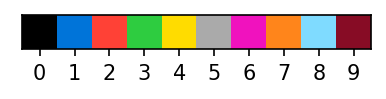

In [ ]:
#| gui
# From: https://www.kaggle.com/code/allegich/arc-2024-show-all-400-training-tasks?scriptVersionId=190186517&cellId=11
# 0:black, 1:blue, 2:red, 3:green, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
# rgb_values = [
#    (0, 0, 0), (0, 116, 217), (255, 65, 54), (46, 204, 64), (255, 220, 0), (170, 170, 170), (240, 18, 190), (255, 133, 27), (127, 219, 255), (135, 12, 37)]
import matplotlib.pyplot as plt
from   matplotlib import colors

cmap = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

plt.figure(figsize=(3, 1), dpi=150)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

{'test': [{'input': [[2, 2], [2, 2]]}], 'train': [{'input': [[3, 3], [3, 3]], 'output': [[4, 4], [4, 4]]}, {'input': [[7, 7], [7, 7]], 'output': [[8, 8], [8, 8]]}, {'input': [[1, 1], [1, 1]], 'output': [[2, 2], [2, 2]]}]}
[[3, 3], [3, 3]]
#15, 00000003


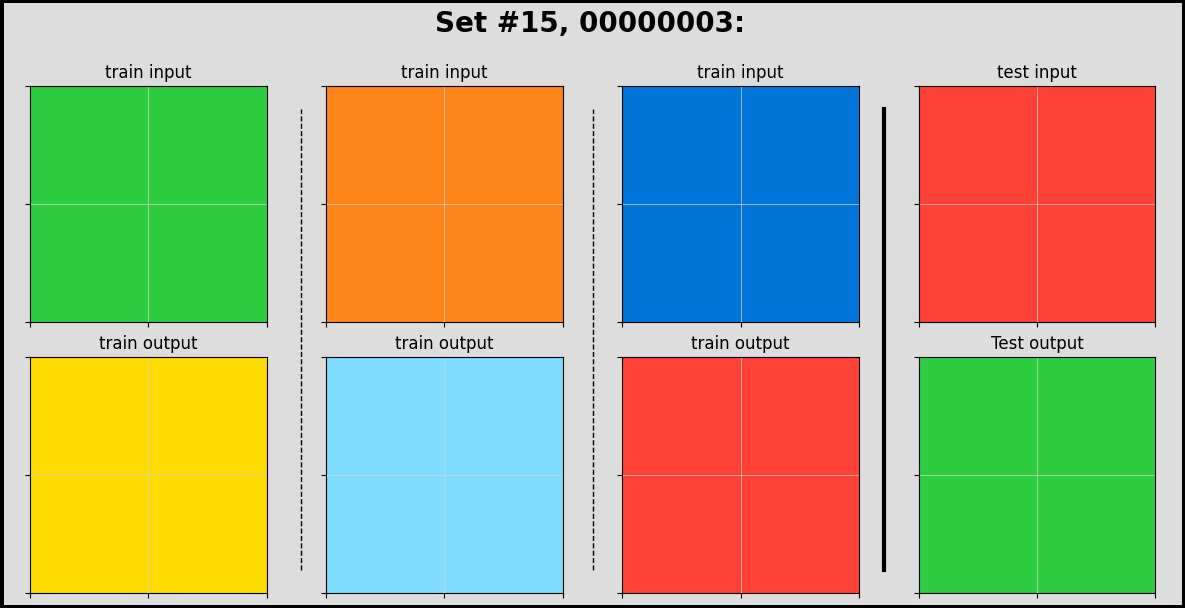

In [ ]:
#| gui
code = '00000003'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)

In [ ]:
#| gui
code = '007bbfb7'
data_mgr.reload_data(folder = 'c:/tmp/arc-prize-2024', prefix = 'arc-agi_training_')
data = data_mgr.get_data_for_code(code)
print(data)
out = data_mgr.get_solutions_for_code(code)
print(out)
print(data_mgr.get_num_arrays_for_code(code))

Execution time of reload_data: 0.1050 seconds
Execution time of reload_data: 0.0130 seconds
{'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]]}], 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], 'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [0, 7, 7, 0, 7, 7, 0, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, 7, 7, 7, 7], [0, 0, 0, 0, 7, 7, 0, 7, 7]]}, {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]], 'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0, 0]]}, {'input': [[0, 0, 0], [0, 0, 2], [2, 0, 2]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0

{'test': [{'input': [[8, 1, 3], [8, 1, 3], [8, 1, 3]]}], 'train': [{'input': [[3, 1, 2], [3, 1, 2], [3, 1, 2]], 'output': [[4, 5, 6], [4, 5, 6], [4, 5, 6]]}, {'input': [[2, 3, 8], [2, 3, 8], [2, 3, 8]], 'output': [[6, 4, 9], [6, 4, 9], [6, 4, 9]]}, {'input': [[5, 8, 6], [5, 8, 6], [5, 8, 6]], 'output': [[1, 9, 2], [1, 9, 2], [1, 9, 2]]}, {'input': [[9, 4, 2], [9, 4, 2], [9, 4, 2]], 'output': [[8, 3, 6], [8, 3, 6], [8, 3, 6]]}]}
[[9, 5, 4], [9, 5, 4], [9, 5, 4]]
#15, 0d3d703e


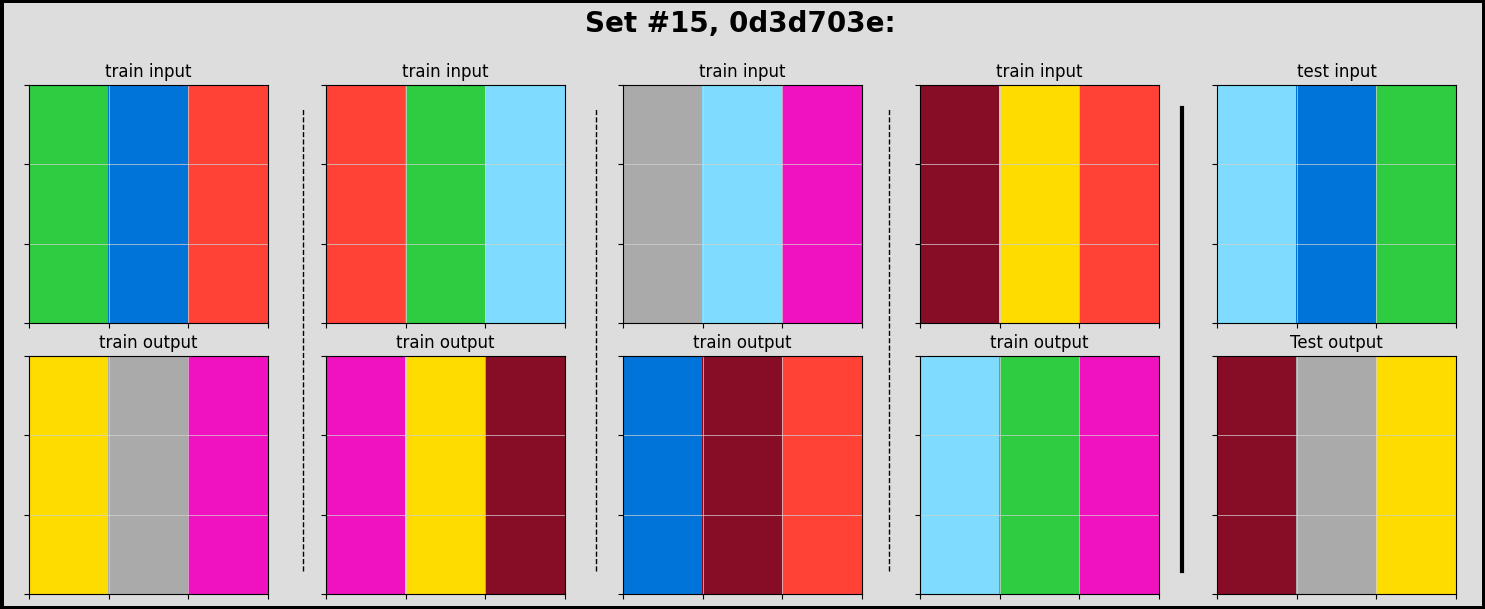

In [ ]:
#| gui
code = '0d3d703e'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)

{'test': [{'input': [[4, 4, 4], [3, 2, 3], [8, 8, 8]]}], 'train': [{'input': [[4, 4, 4], [2, 3, 2], [2, 3, 3]], 'output': [[5, 5, 5], [0, 0, 0], [0, 0, 0]]}, {'input': [[7, 3, 3], [6, 6, 6], [3, 7, 7]], 'output': [[0, 0, 0], [5, 5, 5], [0, 0, 0]]}, {'input': [[2, 9, 2], [4, 4, 4], [9, 9, 9]], 'output': [[0, 0, 0], [5, 5, 5], [5, 5, 5]]}, {'input': [[2, 2, 4], [2, 2, 4], [1, 1, 1]], 'output': [[0, 0, 0], [0, 0, 0], [5, 5, 5]]}]}
[[5, 5, 5], [0, 0, 0], [5, 5, 5]]
#15, 25d8a9c8


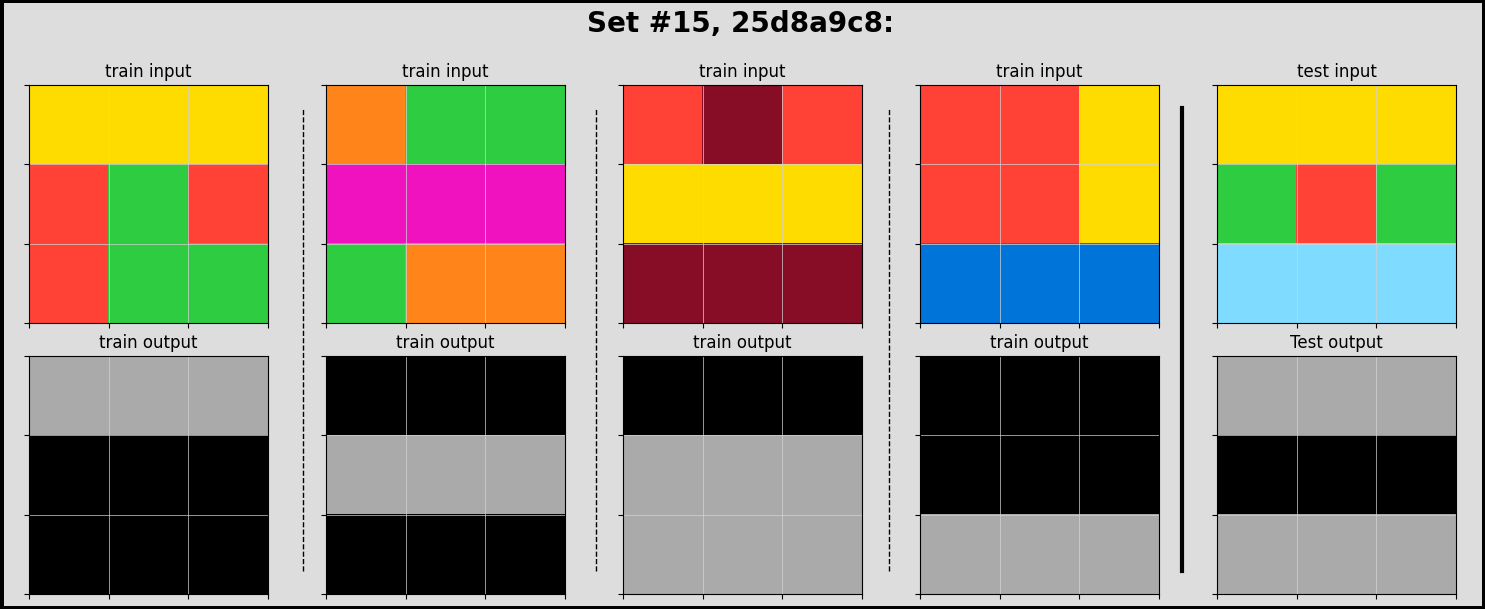

In [ ]:
#| gui
code = '25d8a9c8'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)



{'test': [{'input': [[2, 0, 0], [2, 0, 0], [0, 0, 0]]}, {'input': [[0, 0, 0], [0, 1, 0], [0, 0, 0]]}], 'train': [{'input': [[1, 1, 1], [0, 0, 0], [0, 0, 0]], 'output': [[0, 0, 0], [1, 1, 1], [0, 0, 0]]}, {'input': [[0, 0, 0], [1, 1, 1], [0, 0, 0]], 'output': [[0, 0, 0], [0, 0, 0], [1, 1, 1]]}, {'input': [[0, 1, 0], [1, 1, 0], [0, 0, 0]], 'output': [[0, 0, 0], [0, 1, 0], [1, 1, 0]]}, {'input': [[0, 2, 2], [0, 0, 2], [0, 0, 0]], 'output': [[0, 0, 0], [0, 2, 2], [0, 0, 2]]}]}
[[0, 0, 0], [2, 0, 0], [2, 0, 0]]
#15, 25ff71a9


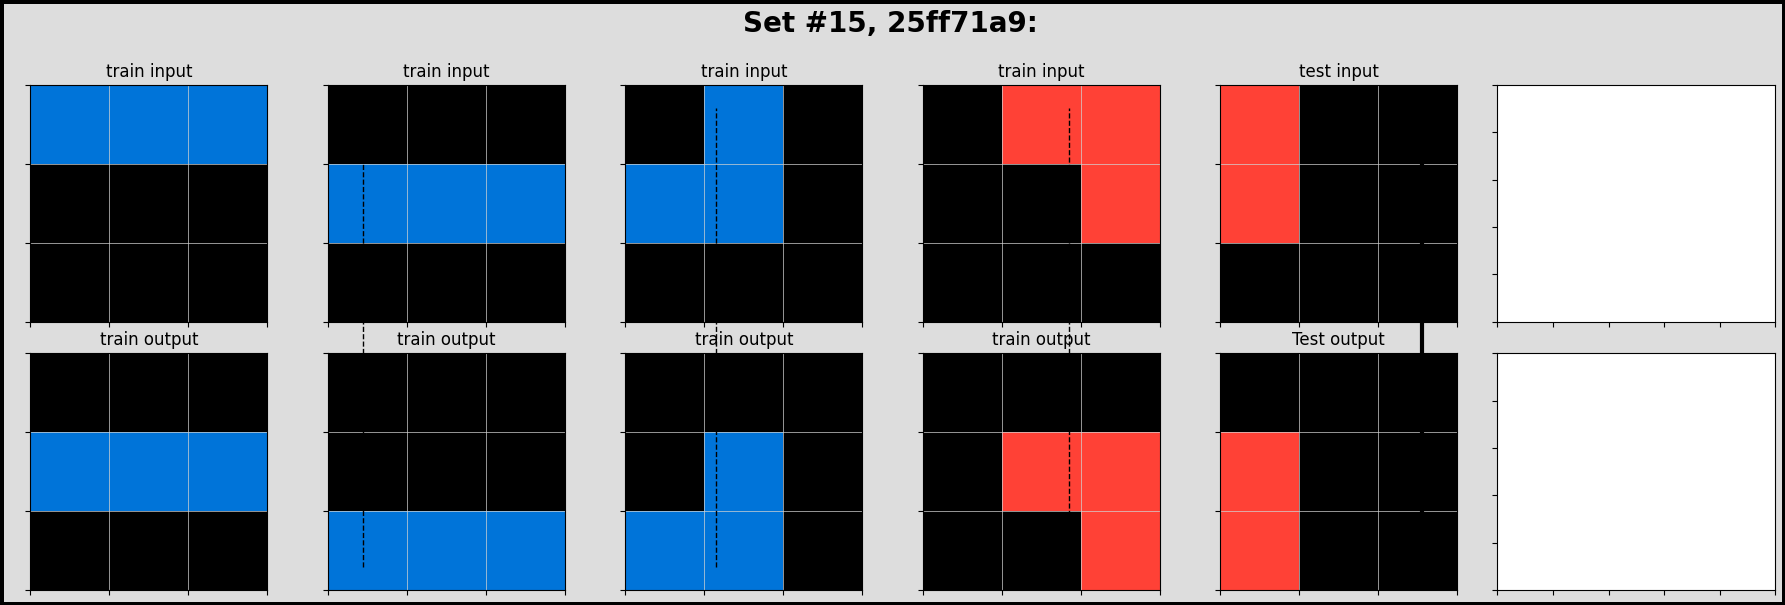

In [ ]:
#| gui
code = '25ff71a9'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)

{'test': [{'input': [[6, 4, 4], [6, 6, 4], [4, 6, 7]]}], 'train': [{'input': [[2, 2, 1], [2, 1, 2], [2, 8, 1]], 'output': [[1, 8, 2], [2, 1, 2], [1, 2, 2]]}, {'input': [[9, 2, 4], [2, 4, 4], [2, 9, 2]], 'output': [[2, 9, 2], [4, 4, 2], [4, 2, 9]]}, {'input': [[8, 8, 8], [5, 5, 8], [8, 5, 5]], 'output': [[5, 5, 8], [8, 5, 5], [8, 8, 8]]}, {'input': [[3, 2, 9], [9, 9, 9], [2, 3, 3]], 'output': [[3, 3, 2], [9, 9, 9], [9, 2, 3]]}]}
[[7, 6, 4], [4, 6, 6], [4, 4, 6]]
#15, 3c9b0459


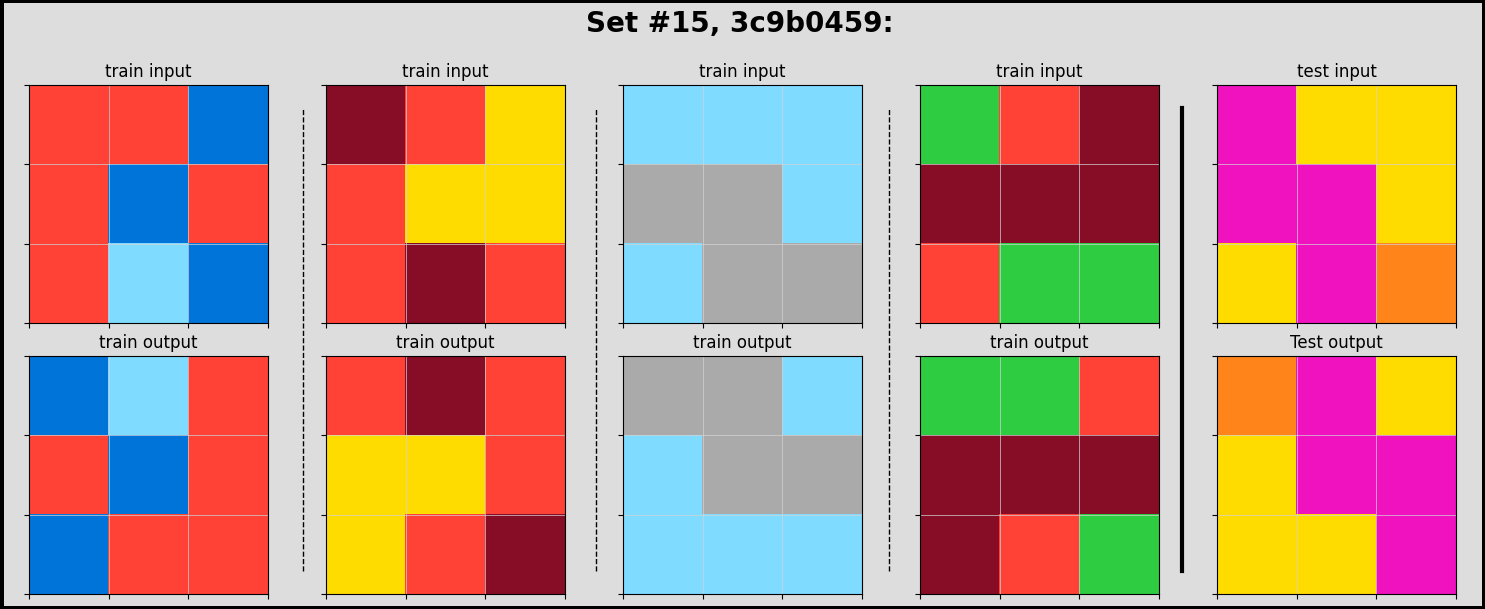

In [ ]:
#| gui
code = '3c9b0459'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)

{'test': [{'input': [[8, 8, 6], [4, 6, 9], [8, 3, 0]]}], 'train': [{'input': [[4, 4, 8], [6, 4, 3], [6, 3, 0]], 'output': [[4, 4, 4], [4, 4, 4], [4, 4, 4]]}, {'input': [[6, 8, 9], [1, 8, 1], [9, 4, 9]], 'output': [[9, 9, 9], [9, 9, 9], [9, 9, 9]]}, {'input': [[4, 6, 9], [6, 4, 1], [8, 8, 6]], 'output': [[6, 6, 6], [6, 6, 6], [6, 6, 6]]}]}
[[8, 8, 8], [8, 8, 8], [8, 8, 8]]
#15, 5582e5ca


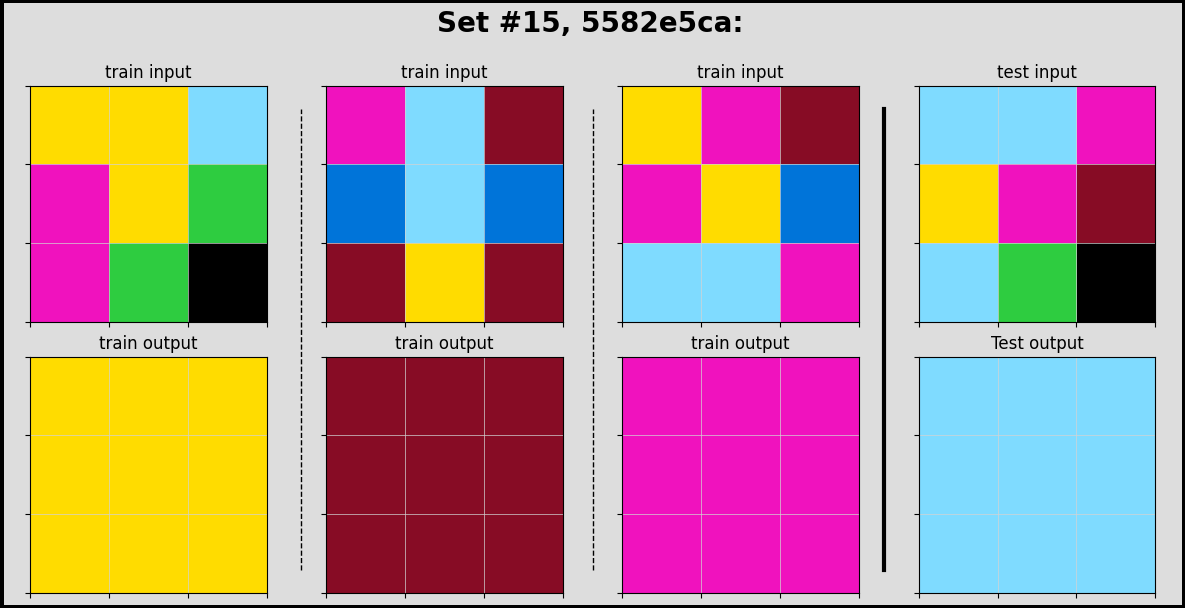

In [ ]:

#| gui
code = '5582e5ca'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)




{'test': [{'input': [[6, 3, 5], [6, 8, 0], [4, 0, 0]]}], 'train': [{'input': [[3, 3, 8], [3, 7, 0], [5, 0, 0]], 'output': [[0, 0, 5], [0, 7, 3], [8, 3, 3]]}, {'input': [[5, 5, 2], [1, 0, 0], [0, 0, 0]], 'output': [[0, 0, 0], [0, 0, 1], [2, 5, 5]]}]}
[[0, 0, 4], [0, 8, 6], [5, 3, 6]]
#15, 6150a2bd


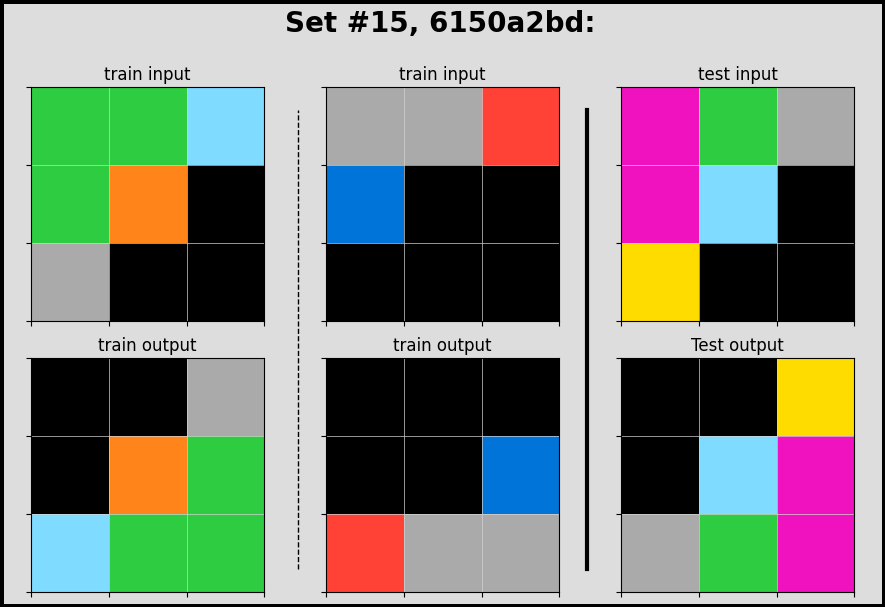

In [ ]:
#| gui
code = '6150a2bd'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)

{'test': [{'input': [[0, 0, 5, 5, 0, 5, 5, 5, 0, 0, 0], [0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0], [0, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0], [0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0], [0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0], [0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 5, 5, 5, 5, 0, 0, 0, 0], [0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0], [0, 0, 0, 5, 5, 5, 5, 5, 0, 0, 0], [0, 0, 0, 5, 0, 0, 5, 5, 0, 0, 0], [0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0], [0, 0, 8, 8, 2, 2, 2, 0, 0, 0, 0], [0, 0, 0, 2, 8, 8, 0, 0, 0, 0, 0], [0, 0, 0, 2, 8, 8, 8, 8, 0, 0, 0], [0, 0, 0, 2, 0, 0, 8, 8, 0, 0, 0], [0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {'input': [[0, 0, 0, 0, 0, 0, 0

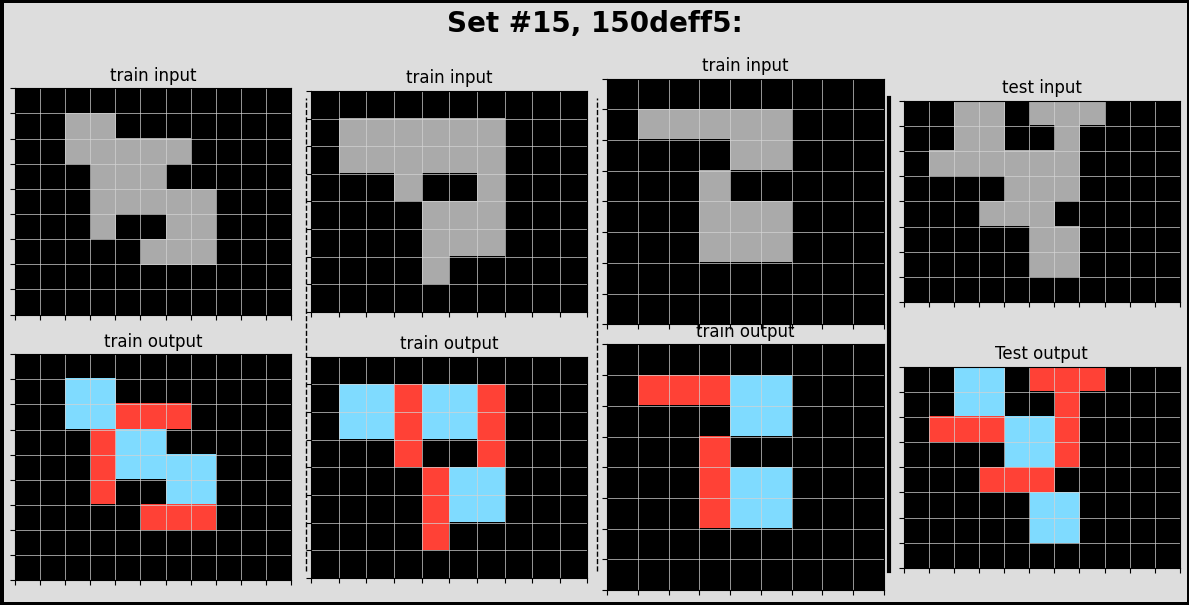

In [ ]:
#| gui
code = '150deff5'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)


{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 8, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 6, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]}], 'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 7, 1, 7, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {'input': [[0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0

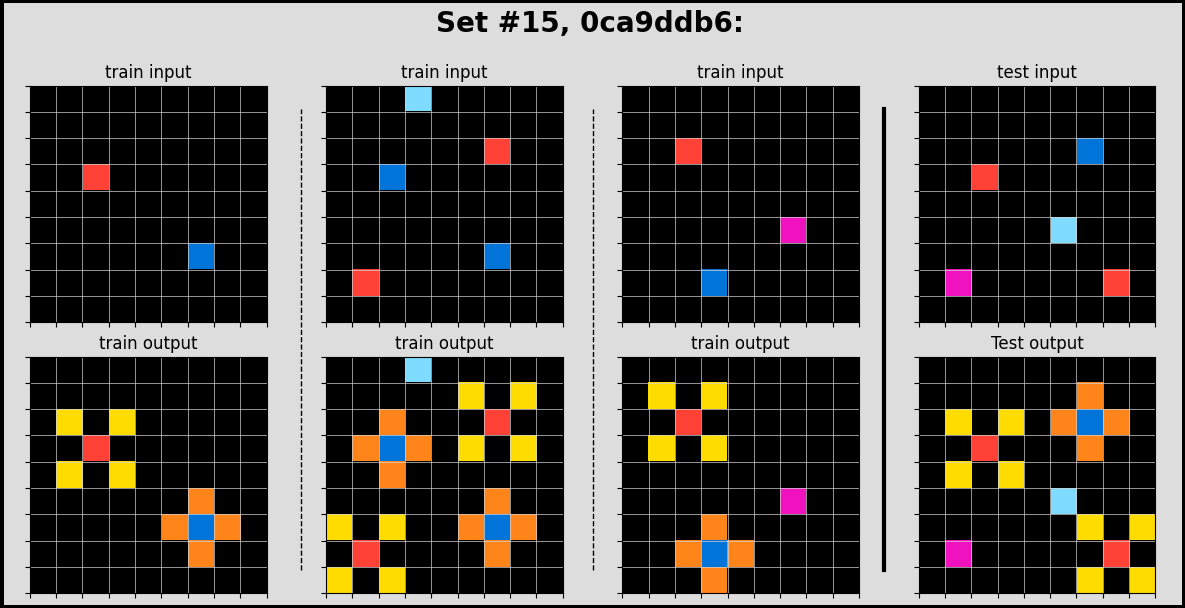

In [ ]:
#| gui
code = '0ca9ddb6'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)

{'test': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0], [0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 

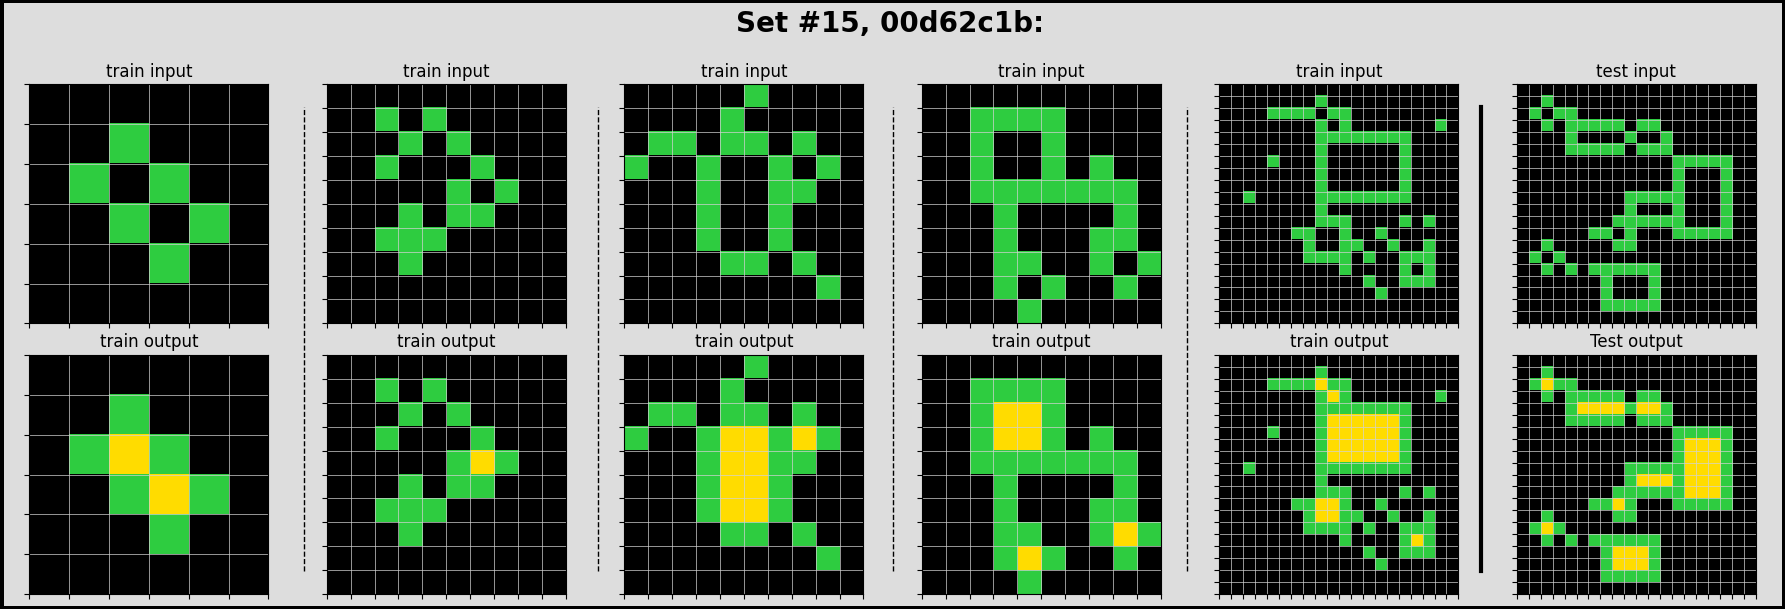

In [ ]:
#| gui
code = '00d62c1b'
task = data_mgr.get_data_for_code(code)
print(task)
task_solution = data_mgr.get_solutions_for_code(code)
print(task_solution)
plot_task(task,  task_solution, 15, code)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()